In [16]:
import pandas as pd
import os
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Correlation for death

## Read raw notes and extract death

In [2]:
data_path = r'/home/mcb/users/pnair6/mimic/data/data_files_14Nov'

In [3]:
fold_note_dfs = [pd.read_csv(os.path.join(data_path, 'fold' + str(idx), 'train.csv')) for idx in range(1, 6)]

In [4]:
fold_note_df = pd.concat(fold_note_dfs, ignore_index=True)

In [5]:
fold_note_df.head()

,Unnamed: 0,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,0,132663.0,2138-09-12 16:09:00,chief complaint: respiratory failure i saw and...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,992
1,1,132663.0,2138-09-12 16:13:00,chief complaint: respiratory distress hpi: yea...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,1520
2,2,132663.0,2138-09-13 04:53:00,demographics day of intubation: day of mechani...,Respiratory,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,231
3,3,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,164
4,4,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,279


In [6]:
death_df = fold_note_df[['HADM_ID', 'DEATH']].drop_duplicates().reset_index(drop=True)
death = death_df['DEATH'].astype(int)

In [7]:
death_df

,HADM_ID,DEATH
0,132663.0,0
1,178961.0,0
2,170269.0,0
3,148625.0,0
4,135916.0,0
...,...,...
1386,115993.0,1
1387,182849.0,1
1388,130887.0,0
1389,194269.0,0


## Read mixtures

In [71]:
# for cross validation datasets
data_path = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2_cv'
fold_dfs = [pd.read_csv(os.path.join(data_path, 'infer', 'f' + str(idx) + '.csv'), header=None) for idx in range(1, 6)]
fold_dfs = [pd.DataFrame(normalize(fold_df.iloc[:,0:51], norm='l1', axis=1)) for fold_df in fold_dfs]
bi_durations = [pd.read_csv(os.path.join(data_path, 'f' + str(idx) + '_bi_vent.txt') , header=None, sep=' ') for idx in range(1, 6)] 
bi_durations = [binary_duration[1].astype(int) for binary_duration in bi_durations]
mixtures = pd.concat(fold_dfs, ignore_index=True)
binary_duration = pd.concat(bi_durations, ignore_index=True)

In [72]:
mixtures.columns = [str(idx) for idx in range(50)]
normed_mixtures = mixtures.copy()
mixtures.shape

(1391, 50)

In [73]:
binary_duration.shape

(1391,)

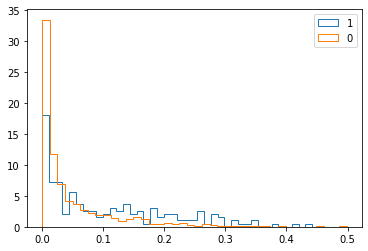

In [114]:
topic_index = '21'
plt.hist(normed_mixtures[topic_index][death == 1], bins=40, density=True, histtype='step', label='1')
plt.hist(normed_mixtures[topic_index][death == 0], bins=40, density=True, histtype='step', label='0')
plt.legend()

In [112]:
mean_diff_sqs = normed_mixtures.apply(lambda mixture: np.abs(mixture[death == 1].mean() - mixture[death == 0].mean()))
# [np.square(normed_mixtures[topic_index][death == 1].mean() - normed_mixtures[topic_index][death == 0].mean()) for topic_index in normed_mixtures.columns]

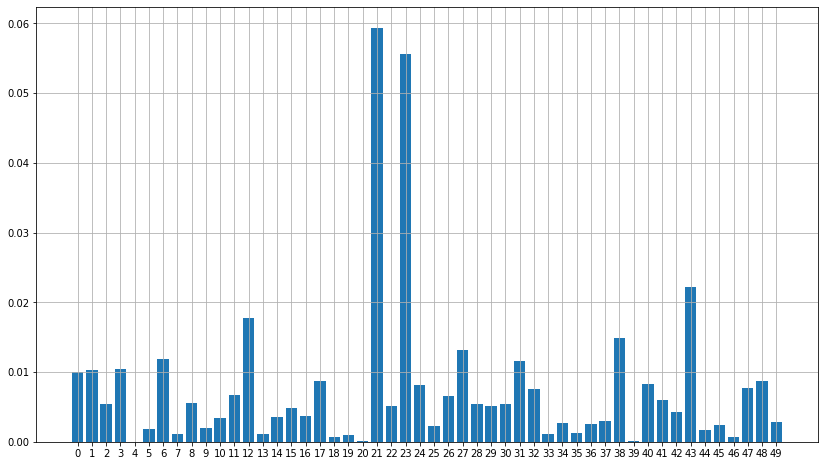

In [138]:
plt.figure(figsize=(14, 8))
plt.bar(normed_mixtures.columns, mean_diff_sqs)
plt.grid()

### Correlation

In [142]:
death_corr = normed_mixtures.apply(lambda mixture: mixture.corr(death, method='pearson'))

In [143]:
death_corr_sorted = death_corr.sort_values(ascending=False)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


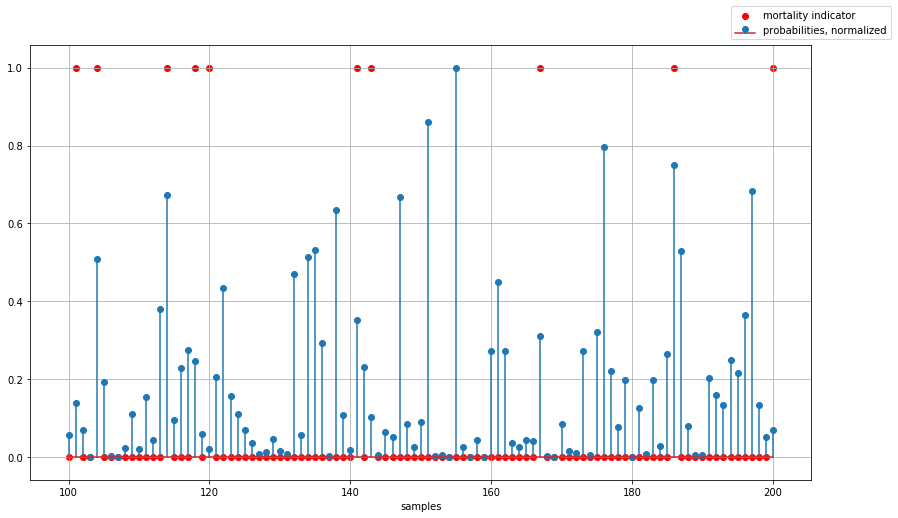

In [144]:
plt.figure(figsize=(14, 8))
plt.stem(normed_mixtures['21'][100:201].index, normed_mixtures['21'][100:201] / max(normed_mixtures['21'][100:201]), label='probabilities, normalized')
plt.scatter(death[100:201].index, death[100:201], c='r', label='mortality indicator')
plt.grid()
plt.xlabel('samples')
plt.legend(loc='upper center', bbox_to_anchor=(1, 1.1))

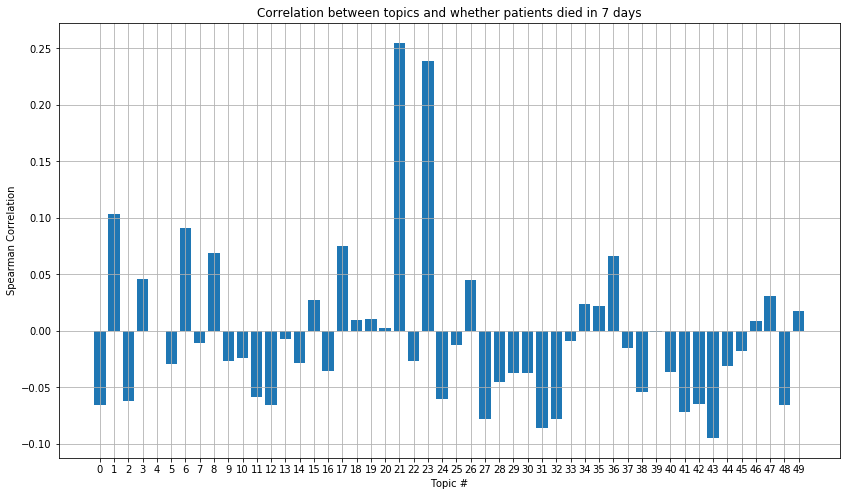

In [145]:
plt.figure(figsize=(14, 8))
plt.bar(x=range(len(death_corr)), height=death_corr, label='correlation with death')
plt.title('Correlation between topics and whether patients died in 7 days')
plt.xlabel('Topic #')
plt.xticks(range(len(death_corr)), death_corr.index)
plt.ylabel('Spearman Correlation')
plt.grid()

### cosine

In [17]:
def cosine(series_1, series_2):
    return np.dot(series_1, series_2) / (np.linalg.norm(series_1, ord=2) * np.linalg.norm(series_2, ord=2))

In [18]:
cos_death_corr = normed_mixtures.apply(lambda mixture: mixture.corr(death, method=cosine))

In [19]:
cos_death_corr_sorted = cos_death_corr.sort_values(ascending=False)

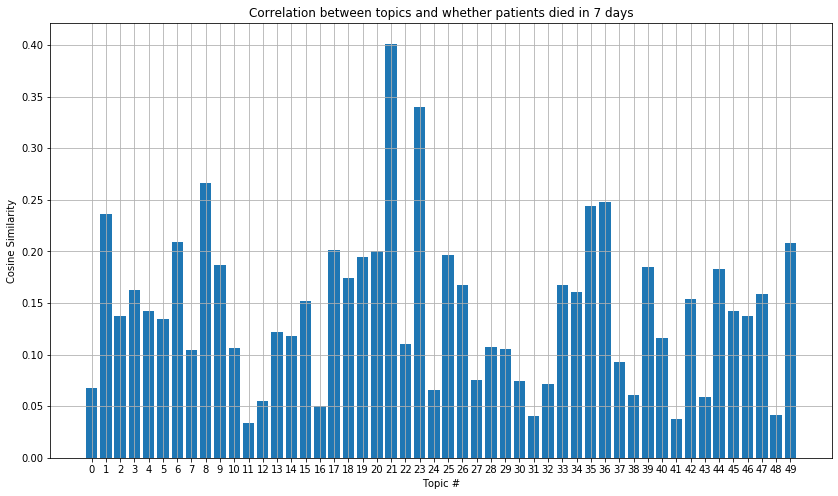

In [45]:
plt.figure(figsize=(14, 8))
plt.bar(x=range(len(cos_death_corr)), height=cos_death_corr, label='correlation with death')
plt.title('Correlation between topics and whether patients died in 7 days')
plt.xlabel('Topic #')
plt.xticks(range(len(cos_death_corr)), cos_death_corr.index)
plt.ylabel('Cosine Similarity')
plt.grid()

### get top patients associated with death

In [22]:
cos_death_corr_sorted.index

Int64Index([21, 23,  8, 36, 35,  1,  6, 49, 17, 20, 25, 19,  9, 39, 44, 18, 26,
            33,  3, 34, 47, 42, 15,  4, 45,  2, 46,  5, 13, 14, 40, 22, 28, 10,
            29,  7, 37, 27, 30, 32,  0, 24, 38, 43, 12, 16, 48, 31, 41, 11],
           dtype='int64')

In [23]:
death_corr_sorted.index

Int64Index([21, 23,  1,  6, 17,  8, 36,  3, 26, 47, 15, 34, 35, 49, 19, 18, 46,
            20,  4, 39, 13, 33,  7, 25, 37, 45, 10,  9, 22, 14,  5, 44, 16, 40,
            29, 30, 28, 38, 11, 24,  2, 42,  0, 48, 12, 41, 32, 27, 31, 43],
           dtype='int64')

In [26]:
normed_mixtures.sort_values(by='21', ascending=False).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
748,0.000460,0.017590,0.000387,0.000460,0.000074,0.006489,0.000504,0.073648,0.003194,0.000233,...,0.000221,0.001790,0.007556,0.000083,0.000172,0.006007,0.000091,0.001619,0.000355,0.008964
1120,0.000979,0.013111,0.002655,0.000221,0.005519,0.010457,0.003438,0.005407,0.205165,0.002008,...,0.029401,0.000210,0.046553,0.000153,0.008544,0.015348,0.017616,0.008802,0.001053,0.002331
273,0.000858,0.005965,0.001512,0.003298,0.002313,0.000315,0.000113,0.177154,0.013795,0.004569,...,0.000439,0.000064,0.018429,0.000838,0.002303,0.089713,0.000077,0.002231,0.000055,0.000067
1238,0.001374,0.016907,0.023209,0.023687,0.000773,0.000312,0.002281,0.012904,0.033034,0.011788,...,0.000129,0.000133,0.018816,0.012928,0.001059,0.021204,0.000375,0.000447,0.000531,0.016439
215,0.000933,0.036865,0.006524,0.008488,0.000269,0.009988,0.000447,0.002811,0.084123,0.010020,...,0.000489,0.000522,0.016273,0.022317,0.000285,0.011172,0.002797,0.000805,0.000442,0.022533


## Map to patients

In [27]:
notes_data_path = r'/home/mcb/users/pnair6/mimic/data/data_files_14Nov'

In [28]:
fold_note_dfs = [pd.read_csv(os.path.join(notes_data_path, 'fold' + str(idx), 'train.csv')) for idx in range(1, 6)]

In [31]:
fold_note_df = pd.concat(fold_note_dfs, ignore_index=True)

In [33]:
fold_note_df.head()

,Unnamed: 0,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,0,132663.0,2138-09-12 16:09:00,chief complaint: respiratory failure i saw and...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,992
1,1,132663.0,2138-09-12 16:13:00,chief complaint: respiratory distress hpi: yea...,Physician,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,1520
2,2,132663.0,2138-09-13 04:53:00,demographics day of intubation: day of mechani...,Respiratory,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,231
3,3,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,164
4,4,132663.0,2138-09-13 03:14:00,year-old female with hypertension admitted wit...,Nursing,249584,2138-08-25 17:58:00,2138-10-03 13:27:00,2138-09-12 11:00:00,2138-10-03 00:00:00,0,20.541667,0,1,0,279


In [34]:
death_df_reset = fold_note_df[['HADM_ID', 'DEATH']].reset_index(drop=True)

In [35]:
death_df_reset.head()

,HADM_ID,DEATH
0,132663.0,0
1,132663.0,0
2,132663.0,0
3,132663.0,0
4,132663.0,0


In [36]:
top_hadm_ids = death_df_reset.iloc[normed_mixtures.sort_values(by='21', ascending=False).head().index]['HADM_ID']

In [37]:
top_hadm_ids

748     163205.0
1120    126791.0
273     105911.0
1238    154794.0
215     135595.0
Name: HADM_ID, dtype: float64

In [38]:
death_df[death_df['HADM_ID'].isin(top_hadm_ids)]

,HADM_ID,DEATH
7,135595.0,0
9,105911.0,0
29,163205.0,0
42,126791.0,0
46,154794.0,0
